In [1]:
%load_ext rpy2.ipython

In [127]:
%%R

nn <- 2000
mu1 <- 0
sd1 <- 1
mu2 <- 5
sd2 <- 0.5
x1 <- rnorm(nn, mu1, sd1)
x2 <- rnorm(nn, mu2, sd2)

lambda1 <- 1
lambda2 <- 8
y1 <- rpois(nn, lambda1)
y2 <- rpois(nn, lambda2)


p1 <- 0.3
p2 <- 1 - p1

realPars <- list(mu1 = mu1, sd1 = sd1, mu2 = mu2, sd2 = sd2, 
                 lambda1 = lambda1, lambda2 = lambda2, 
                 p1 = p1, p2 = p2)
pS <- sample(c(p1, p2), length(x), replace=TRUE, prob = c(p1, p2))

x <- apply(cbind(x1, x2), 1, function(xRow) sample(xRow, prob = c(p1, p2)))

y <- apply(cbind(y1, y2), 1, function(yRow) sample(yRow, prob = c(p1, p2)))

x <- apply(cbind(x1, x2, pS), 1, function(xRow) ifelse(xRow[3] < 0.5, xRow[1], xRow[2]))
y <- apply(cbind(y1, y2, pS), 1, function(xRow) ifelse(xRow[3] < 0.5, xRow[1], xRow[2]))
    
  
   table(pS)

pS
 0.3  0.7 
 602 1398 


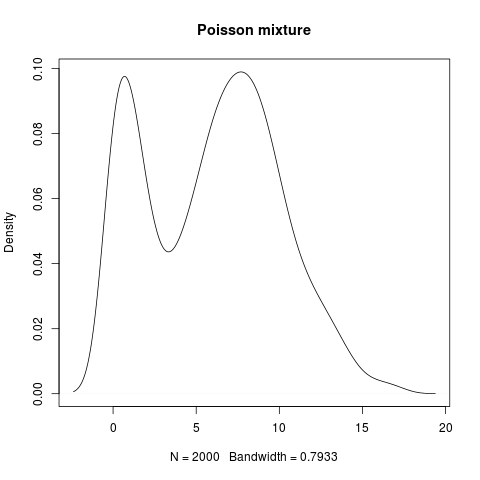

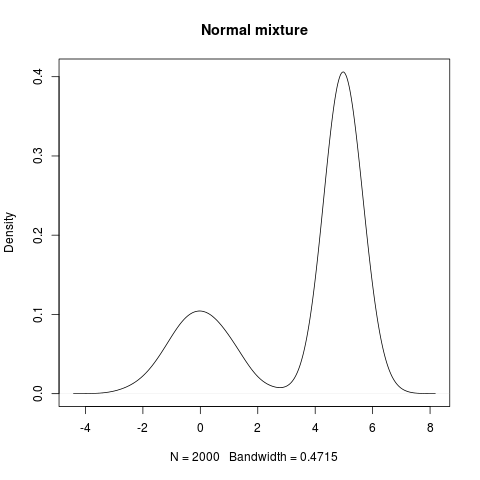

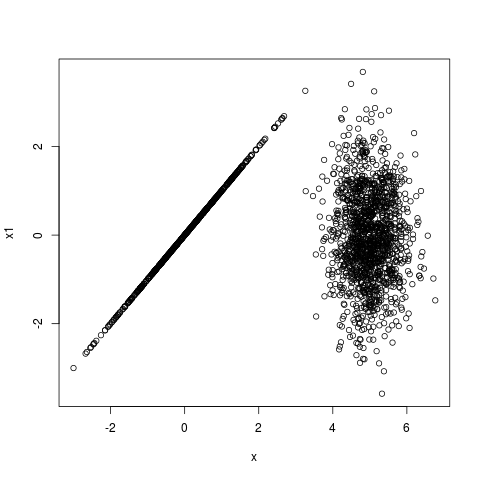

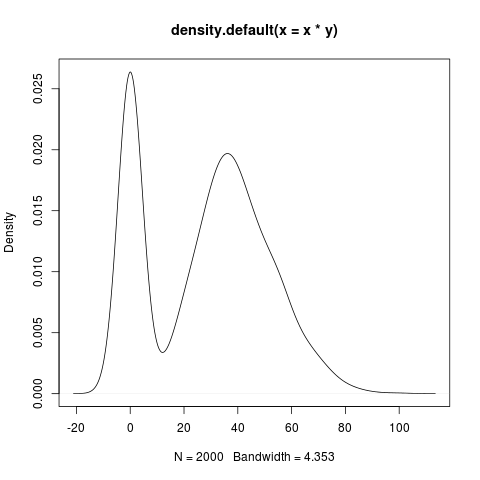

In [192]:
%%R
plot(density(x), main = 'Normal mixture')
plot(density(y), main = 'Poisson mixture')

plot(x, x1)

plot(density(x*y))

In [132]:
%%R
llk <- function(x){
    mu1 <- x[1]
    sd1 <- x[2]
    mu2 <- x[3]
    sd2 <- x[4]
    
    lambda1 <- x[5]
    lambda2 <- x[6]
    
    pi0 <- x[7]

    
    -sum(log(pi0*dnorm(xNorm, mean = mu1, sd = sd1)*dpois(xPois, lambda1) + 
            (1 - pi0)*dnorm(xNorm, mean = mu2, sd = sd2)*dpois(xPois, lambda2)))
}

In [135]:
%%R
xNorm <- x
xPois <- y
pi0 <- p1
library("optimx")

bb <- optimx(par = c(mu1 - 0.5, sd1 + 0.5, mu2 + 0.3, sd2 + 0.5, lambda1 + 2, lambda2 + 3, pi0 + 0.1), 
             fn = llk)
             

In [136]:
%%R
bb

                       p1       p2       p3        p4       p5       p6
Nelder-Mead -0.0035276108 1.034362 4.991998 0.5046331 1.015182 8.077438
BFGS         0.0008958782 1.030670 4.990386 0.5044510 1.013362 8.080956
                   p7    value fevals gevals niter convcode  kkt1 kkt2 xtimes
Nelder-Mead 0.3015494 7312.792    502     NA    NA        1 FALSE TRUE   0.48
BFGS        0.3010405 7312.769     70     17    NA        0  TRUE TRUE   0.30


In [181]:
%%R
library('rjags')
dataJags <- list(xNormal = as.numeric(x),
                xPoisson = as.numeric(y),
                N = length(x),
                lambda1 = lambda1,
                lambda2 = lambda2,
                mu1 = mu1, mu2 = mu2,
                sd1 = sd1, sd2 = sd2,
                alpha0 = c(1, 1))

jagsFile = "model{
#    p0 ~ dbeta(1, 2)
    p0 ~ ddirch(alpha0)
    
 #   inDex ~ dbern(p0)
  #  groupIndex <- inDex + 1
    
    muF[1] ~ dnorm(mu1, 0.001)
    muF[2] ~ dnorm(mu2, 0.001)
    sdF[1] ~ dgamma(sd1*10, 10)
    sdF[2] ~ dgamma(sd2*10, 10)
    
    lambdaF[1] ~ dnorm(lambda1, 0.001)
    lambdaF[2] ~ dnorm(lambda2, 0.001)
    
    for (i in 1:N){
        xNormal[i] ~ dnorm(mu0[i], tau0[i])
    #    mu0[i] <- muF[groupIndex]
        mu0[i] <- muF[T[i]]
        #tau0[i] <- 1/sdF[groupIndex]^2
        tau0[i] <- 1/sdF[T[i]]^2

        xPoisson[i] ~ dpois(lambda0[i])
#        lambda0[i] <- lambdaF[groupIndex]
        lambda0[i] <- lambdaF[T[i]]
    T[i] ~ dcat(p0)
    }
}"

In [182]:
%%R
n.chains = 1
n.adapt = 100
mixture1 <- jags.model(textConnection(jagsFile),# inits = inits,
                              data = dataJags, n.chains = n.chains, n.adapt = n.adapt)



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 16023

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%


In [183]:
%%R
nUpdate = 5000
update(mixture1, nUpdate)

n.iter = 5000
thin = 1


  |**************************************************| 100%


In [184]:
%%R
xem1 <- coda.samples(mixture1, c('muF', 'sdF', 'lambdaF', 'p0', 'groupIndex'),
                    n.iter = n.iter, thin = thin)
##Each chain will produce a list


  |**************************************************| 100%


In [185]:
%%R
a1 <- xem1[[1]]

dim(a1)

apply(a1, 2, mean)

 lambdaF[1]  lambdaF[2]      muF[1]      muF[2]       p0[1]       p0[2] 
1.014662148 8.081146336 0.001291718 4.990599184 0.301278721 0.698721279 
     sdF[1]      sdF[2] 
1.032486956 0.504911571 


In [186]:
%%R
#table(a1[, 'groupIndex'])

NULL


In [187]:
%%R
realPars

$mu1
[1] 0

$sd1
[1] 1

$mu2
[1] 5

$sd2
[1] 0.5

$lambda1
[1] 1

$lambda2
[1] 8

$p1
[1] 0.3

$p2
[1] 0.7



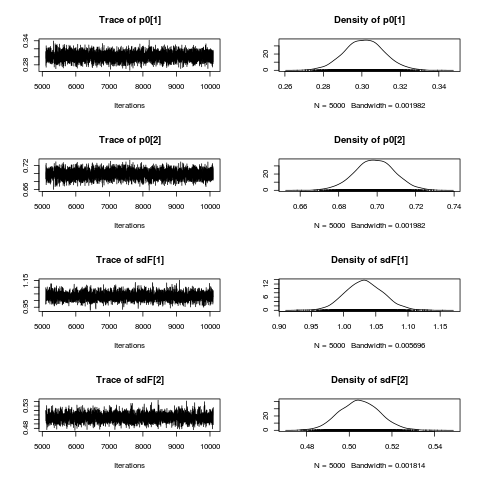

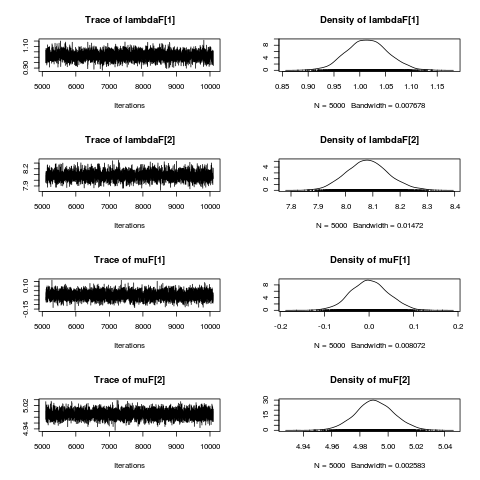

In [188]:
%%R 
plot(a1)

In [190]:
#!gist -p test_combine_mixture_models.ipynb

In [191]:
!gist -u https://gist.github.com/72f1c20e2d3790fa0673 test_combine_mixture_models.ipynb

https://gist.github.com/72f1c20e2d3790fa0673
